--- Đã tải dữ liệu của QS từ file data/QS_01_11.csv.

✅ KẾT QUẢ ĐÁNH GIÁ HIỆU SUẤT CHO MÃ QS:
                      Total Return Sharpe Ratio Max Drawdown
1. Buy & Hold              -10.75%        -0.03      -91.45%
2. SMA Crossover           -19.74%        -0.13      -68.57%
3. Momentum (252D)         187.61%         0.49      -58.77%
4. BB Mean Reversion         0.00%          nan        0.00%
5. RSI Mean Reversion       47.36%         0.32      -32.85%


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25892\3591408261.py:103: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)


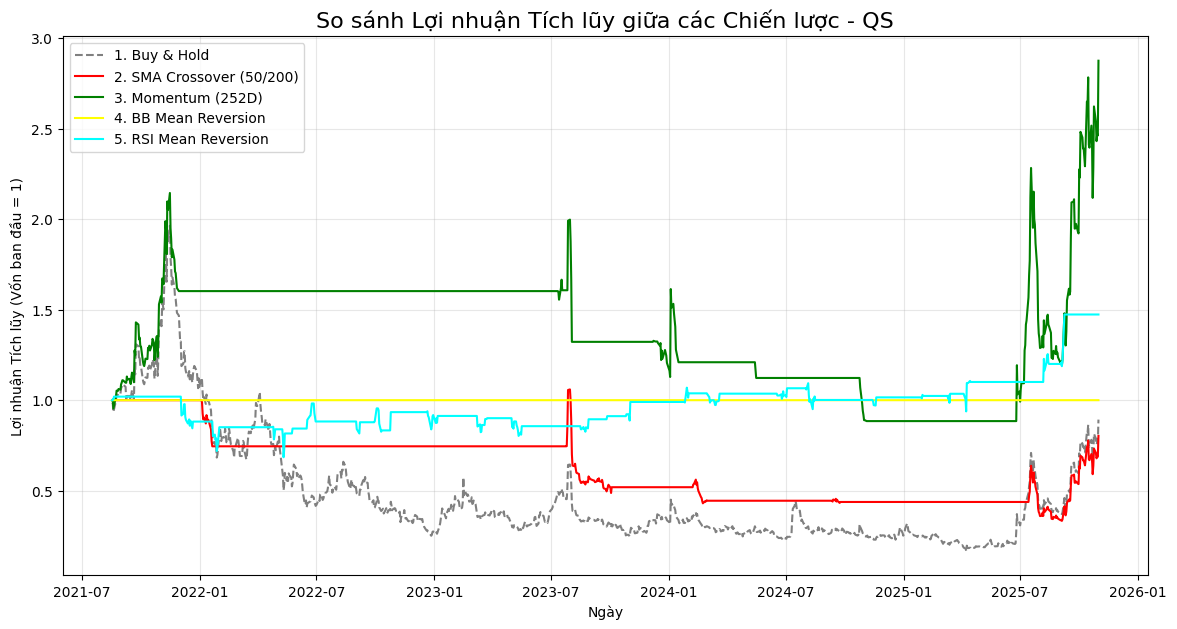

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Đường dẫn đến thư mục chứa dữ liệu đã tải từ data_01.ipynb
DATA_FOLDER = 'data/'

# ====================================================================
# PHẦN 1: TẢI VÀ XỬ LÝ DỮ LIỆU CƠ BẢN
# ====================================================================

def load_stock_data(ticker_symbol: str):
    """
    Đọc dữ liệu đã lưu từ file CSV trong thư mục 'data/'.
    """
    base_ticker = ticker_symbol.split('_')[0]
    file_name = f"{base_ticker}_01_11.csv"
    file_path = os.path.join(DATA_FOLDER, file_name)

    if not os.path.exists(file_path):
        print(f"LỖI: Không tìm thấy file dữ liệu {file_path}. Vui lòng kiểm tra lại tên file và thư mục.")
        return None

    try:
        # Đọc file CSV. Cột đầu tiên (Index) được giả định là cột 'Date'.
        data = pd.read_csv(file_path, index_col=0, parse_dates=True)
        data.reset_index(inplace=True)
        if 'index' in data.columns:
             data.rename(columns={'index': 'Date'}, inplace=True)
        elif data.columns[0] != 'Date':
             data.rename(columns={data.columns[0]: 'Date'}, inplace=True)

        print(f"--- Đã tải dữ liệu của {base_ticker} từ file {file_path}.")
        return data

    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None

def process_data_and_calculate_indicators(data: pd.DataFrame):
    """
    Tính toán Lợi suất (Returns) và các Chỉ báo Kỹ thuật (SMA, Momentum, BB, RSI).
    """
    data['Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

    # 1. Chỉ báo SMA (Trend-following)
    data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Adj Close'].rolling(window=200).mean()

    # 2. Chỉ báo Momentum (Đà tăng trưởng)
    data['Momentum_252D'] = data['Adj Close'].pct_change(periods=252)

    # 3. Chỉ báo Bollinger Bands (Mean-Reversion)
    BB_WINDOW = 20
    BB_STD = 2
    data['SMA_BB'] = data['Adj Close'].rolling(window=BB_WINDOW).mean()
    data['STD_BB'] = data['Adj Close'].rolling(window=BB_WINDOW).std()
    data['Lower_Band'] = data['SMA_BB'] - (data['STD_BB'] * BB_STD)

    # 4. Chỉ báo RSI (Relative Strength Index) (MÔ HÌNH MỚI)
    RSI_PERIOD = 14
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=RSI_PERIOD).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=RSI_PERIOD).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))

    # 5. Chỉ báo MFI (Money Flow Index) (MÔ HÌNH MỚI)
    MFI_PERIOD = 14

    # Tính Typical Price (Giá điển hình)
    data['TP'] = (data['High'] + data['Low'] + data['Close']) / 3

    # Tính Money Flow (Dòng tiền)
    data['Money_Flow'] = data['TP'] * data['Volume']

    # Xác định Positive Money Flow (PMF) và Negative Money Flow (NMF)
    data['PMF'] = np.where(data['TP'] > data['TP'].shift(1), data['Money_Flow'], 0)
    data['NMF'] = np.where(data['TP'] < data['TP'].shift(1), data['Money_Flow'], 0)

    # Tính Money Flow Ratio (MFR)
    PMF_sum = data['PMF'].rolling(window=MFI_PERIOD).sum()
    NMF_sum = data['NMF'].rolling(window=MFI_PERIOD).sum()

    # Tính MFI
    data['MFI'] = 100 - (100 / (1 + (PMF_sum / NMF_sum)))

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

# ====================================================================
# PHẦN 2: HÀM ĐÁNH GIÁ VÀ BACKTEST
# ====================================================================

def evaluate_strategy(data: pd.DataFrame, strategy_col: str):
    """
    Đánh giá hiệu suất: Total Return, Sharpe Ratio, Max Drawdown.
    """
    strategy_returns = data[strategy_col]
    cumulative_returns = np.exp(strategy_returns.cumsum().iloc[-1])
    sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)

    cumulative_series = np.exp(strategy_returns.cumsum())
    peak = cumulative_series.expanding(min_periods=1).max()
    drawdown = (cumulative_series / peak) - 1.0
    mdd = drawdown.min()

    return cumulative_returns - 1, sharpe_ratio, mdd

def backtest_strategies(data: pd.DataFrame, ticker: str):
    """
    Thiết kế và kiểm tra ngược 5 chiến lược.
    """
    # ... (Code cho Buy & Hold, SMA Crossover, Momentum 252D giữ nguyên) ...
    data['Strategy_Returns_BnH'] = data['Returns'] * 1.0
    data['Signal_SMA'] = np.where(data['SMA_50'] > data['SMA_200'], 1.0, 0.0)
    data['Position_SMA'] = data['Signal_SMA'].shift(1).fillna(0)
    data['Strategy_Returns_SMA'] = data['Returns'] * data['Position_SMA']
    data['Signal_Mom'] = np.where(data['Momentum_252D'] > 0, 1.0, 0.0)
    data['Position_Mom'] = data['Signal_Mom'].shift(1).fillna(0)
    data['Strategy_Returns_Mom'] = data['Returns'] * data['Position_Mom']

    # --- Chiến lược 4: Bollinger Band Mean Reversion ---
    buy_condition_bb = (data['Adj Close'].shift(1) < data['Lower_Band'].shift(1)) & \
                       (data['Adj Close'] > data['Adj Close'].shift(1))
    sell_condition_bb = (data['Adj Close'] < data['SMA_BB']) # Thoát khi giá chạm SMA giữa
    data['Signal_BB'] = 0.0
    data.loc[buy_condition_bb, 'Signal_BB'] = 1.0
    data.loc[sell_condition_bb, 'Signal_BB'] = 0.0
    data['Position_BB'] = data['Signal_BB'].ffill().shift(1).fillna(0)
    data['Strategy_Returns_BB'] = data['Returns'] * data['Position_BB']

    # --- Chiến lược 5: RSI Mean Reversion (MÔ HÌNH MỚI) ---
    # Mua (Long): RSI quá bán (dưới 30)
    buy_condition_rsi = data['RSI'] <= 30
    # Bán (Exit): RSI hồi phục đến mức trung bình (trên 50)
    sell_condition_rsi = data['RSI'] >= 50

    data['Signal_RSI'] = 0.0
    data.loc[buy_condition_rsi, 'Signal_RSI'] = 1.0
    data.loc[sell_condition_rsi, 'Signal_RSI'] = 0.0

    # Giữ vị thế cho đến khi có tín hiệu ngược lại
    data['Position_RSI'] = data['Signal_RSI'].ffill().shift(1).fillna(0)
    data['Strategy_Returns_RSI'] = data['Returns'] * data['Position_RSI']


    # --- Đánh giá Hiệu suất và Xuất Bảng Kết quả ---
    results = {}
    results['1. Buy & Hold'] = evaluate_strategy(data, 'Strategy_Returns_BnH')
    results['2. SMA Crossover'] = evaluate_strategy(data, 'Strategy_Returns_SMA')
    results['3. Momentum (252D)'] = evaluate_strategy(data, 'Strategy_Returns_Mom')
    results['4. BB Mean Reversion'] = evaluate_strategy(data, 'Strategy_Returns_BB')
    results['5. RSI Mean Reversion'] = evaluate_strategy(data, 'Strategy_Returns_RSI') # NEW

    print(f"\n✅ KẾT QUẢ ĐÁNH GIÁ HIỆU SUẤT CHO MÃ {ticker}:")
    df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Total Return', 'Sharpe Ratio', 'Max Drawdown'])

    df_results['Total Return'] = (df_results['Total Return'] * 100).map('{:.2f}%'.format)
    df_results['Sharpe Ratio'] = df_results['Sharpe Ratio'].map('{:.2f}'.format)
    df_results['Max Drawdown'] = (df_results['Max Drawdown'] * 100).map('{:.2f}%'.format)

    print(df_results)

    # --- Vẽ Biểu đồ Kết quả ---
    data['Cumulative_BnH'] = np.exp(data['Strategy_Returns_BnH'].cumsum())
    data['Cumulative_SMA'] = np.exp(data['Strategy_Returns_SMA'].cumsum())
    data['Cumulative_Mom'] = np.exp(data['Strategy_Returns_Mom'].cumsum())
    data['Cumulative_BB'] = np.exp(data['Strategy_Returns_BB'].cumsum())
    data['Cumulative_RSI'] = np.exp(data['Strategy_Returns_RSI'].cumsum()) # NEW

    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Cumulative_BnH'], label='1. Buy & Hold', color='gray', linestyle='--')
    plt.plot(data['Date'], data['Cumulative_SMA'], label='2. SMA Crossover (50/200)', color='red')
    plt.plot(data['Date'], data['Cumulative_Mom'], label='3. Momentum (252D)', color='green')
    plt.plot(data['Date'], data['Cumulative_BB'], label='4. BB Mean Reversion', color='yellow')
    plt.plot(data['Date'], data['Cumulative_RSI'], label='5. RSI Mean Reversion', color='cyan') # NEW

    plt.title(f'So sánh Lợi nhuận Tích lũy giữa các Chiến lược - {ticker}', fontsize=16)
    plt.xlabel('Ngày')
    plt.ylabel('Lợi nhuận Tích lũy (Vốn ban đầu = 1)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ====================================================================
# CHƯƠNG TRÌNH CHÍNH
# ====================================================================

if __name__ == "__main__":
    tickers_input = input("Nhập mã cổ phiếu cần xây dựng chiến lược (ví dụ: ALAB, ROKU): ").strip()
    tickers = [t.strip().upper().split('_')[0] for t in tickers_input.split(",") if t.strip() != ""]

    if not tickers:
        print("Vui lòng nhập ít nhất một mã cổ phiếu hợp lệ.")
    else:
        for ticker in tickers:
            data_loaded = load_stock_data(ticker)

            if data_loaded is not None:
                data_processed = process_data_and_calculate_indicators(data_loaded.copy())

                if data_processed is not None:
                    backtest_strategies(data_processed.copy(), ticker)